# Tutorial 02: Designing an adversary

In order for an attack to be executed a model for how attacking vehicles should behave. In Anti-Flow this is done by taking advantage of the controller class in Flow, which specifies different components for how vehicles driver. In this tutorial we present the basic architecture for writing a car-following controller and then a lane-changing controller. We then implement simple adversarial controllers of those types, which we then simulate attacking a traffic flow.

Here we present the basic structure for a car-following controller:

In [4]:
# First, we import a Base Controller, which other controllers inherit from:
import numpy as np
from Adversaries.controllers.base_controller import BaseController

Let's start with a car-following controller. These dictate how a car moves laterally, and in Anti-Flow/Flow are typically acceleration based, and in the traffic literature are commonly referred to as car-following models (CFMs). First, we're going to design a 'normal' cfm, representing a non attacked vehicle, which uses the popular 'Bando Optimal-velocity Follow-the-leader' model [1].

In [6]:
class cfm_non_adversarial(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 a=0.8,
                 b=20.0,
                 s0=1.0,
                 s1=2.0,
                 Vm=15.0):
        #Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        # Model parameters, which can be changed at initialization:
        self.Vm = Vm
        self.s0 = s0
        self.s1 = s1
        self.a = a
        self.b = b
        
    def get_accel(self, env):
        """This function is queried during simulation
           to acquire an acceleration value:"""
        # env contains all information on the simulation, and 
        # can be queried to get the state of different vehicles.
        # We assume this vehicle has access only to its own state,
        # and the position/speed of the vehicle ahead of it. 
        lead_id = env.k.vehicle.get_leader(self.veh_id) #Who is the leader
        v_l = env.k.vehicle.get_speed(lead_id) #Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) #vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) #inter-vehicle spacing to leader

        # We build this model off the popular Bando OV-FTL model:
        v_opt = self.OV(self,v,s)
        ftl = self.(self,v,v_l,s)
        u = self.a*(v_opt - v) + self.b*ftl
        
        return u #return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """This function can be queried at any time,
           and is useful for analyzing controller
           behavior outside of a sim."""
        v_opt = self.OV(self,v,s)
        ftl = self.(self,v,v_l,s)
        u = self.a*(v_opt - v) + self.b*ftl
        return u
    
    def OV(self,v,s):
        return self.Vm*((np.tanh(s/self.s0-self.s1)+np.tanh(self.s1))/(1+np.tanh(self.s1)))
    
    def FTL(self,v,v_l,s):
        return (v_l-v)/(s**2)

The two main components needed for this controller are get_accel(), which is called within the Flow simulation to advance the motion of vehicles, and get_custom_accel(), which should reflect the same model as get_accel(), but accepts generic inputs, rather than the state of the simulation (env). 

Let's now initialize and run a simulation on the ring-road to check the behavior of this model. We encourage you to experiment with changing the structure of the proposed CFM. 

In [20]:
#Import different needed quantities:
from flow.networks.ring import RingNetwork
from flow.core.params import VehicleParams
from flow.controllers.routing_controllers import ContinuousRouter #Router that keeps vehicles on the ring-road
from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.core.params import NetParams
from flow.core.params import InitialConfig
from flow.core.params import TrafficLightParams
from flow.envs.ring.accel import AccelEnv
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS
from flow.core.params import SumoParams
from flow.core.params import EnvParams
from flow.core.experiment import Experiment

#Initialize simulation environemnt:
time_step = 0.1 #In seconds, how far each step of the simulation goes.
ring_length = 300 #The diameter of the ring-road
emission_path = 'data' #Where
want_render = True #If we want SUMO to render the environment and display the simulation.
sim_horizon = 3000 #How many simulation steps will be taken -> Runs for 300 seconds

traffic_lights = TrafficLightParams() #This is empty, so no traffic lights are used.
initial_config = InitialConfig(spacing="uniform", perturbation=1) #Vehicles start out evenly spaced.
vehicles = VehicleParams() #The vehicles object will store different classes of drivers:
sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) #Sets the simulation time-step and where data will be recorded.
env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)
net_params = NetParams(additional_params={'length':ring_length,
                                          'lanes':1,
                                          'speed_limit': 30,
                                          'resolution': 40})


#Specify how human driven vehicles will drive:
num_human_drivers = 10
# Define a driver model human drivers:
vehicles.add("human",
             acceleration_controller=(cfm_non_adversarial, {'Vm':2.0,'noise':0.05}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=num_human_drivers)

#initialize the simulation:
flow_params = dict(
    exp_tag='ring_no_attack',
    env_name=AccelEnv,
    network=RingNetwork,
    simulator='traci',
    sim=sim_params,
    env=env_params,
    net=net_params,
    veh=vehicles,
    initial=initial_config,
    tls=traffic_lights,
)

# number of time steps
flow_params['env'].horizon = sim_horizon
exp = Experiment(flow_params)
print('Simulation ready.')

Simulation ready.


Run the simulation:

In [21]:
#Run the simulation and save the data:
sim_res_list = exp.run(1, convert_to_csv=True)

Round 0, return: 160.27413082612225
data/ring_no_attack_20211220-1647481640036868.266154-0_emission.csv data
Average, std returns: 160.27413082612225, 0.0
Average, std velocities: 19.04997433772707, 0.0
Average, std outflows: 0.0, 0.0
Total time: 53.138341188430786
steps/second: 70.07821440030301


/Users/vanderbilt/Desktop/Research_2021/Anti-Flow/tutorials/data/ring_no_attack_20211220-1647481640036868.266154-0_emission.csv
Data loaded.


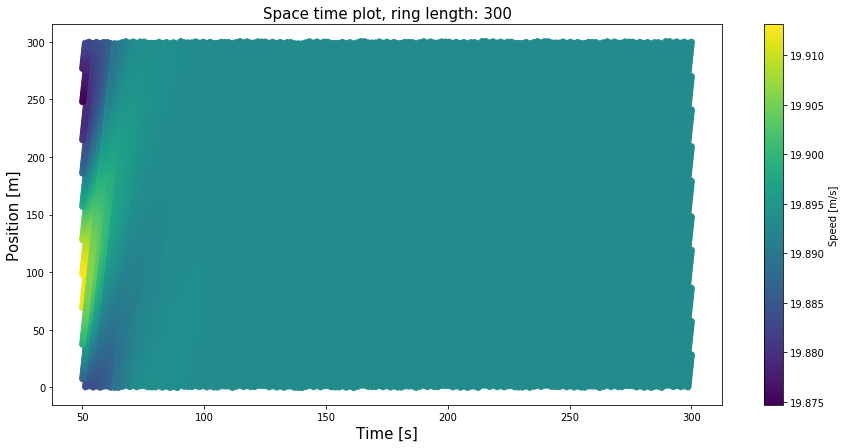

In [23]:
import os
import flow.visualize.visualize_ring as visualize_ring
from importlib import reload 
reload(visualize_ring)

emission_location = os.path.join(os.getcwd(),sim_res_list[1])
print(emission_location)
visualize_ring.make_ring_spacetime_fig(csv_path = emission_location)

Now, let's define a ne controller which is adversarial in nature. It will follow the same basic structure, but will also add in periods of malicious behavior.

In [ ]:
class cfm_non_adversarial(BaseController):
    def __init__(self,
                 veh_id,
                 car_following_params,
                 delay=0.0,
                 noise=0.0,
                 fail_safe=None,
                 a=0.8,
                 b=20.0,
                 s0=1.0,
                 s1=2.0,
                 Vm=15.0):
        #Inherit the base controller:
        BaseController.__init__(
            self,
            veh_id,
            car_following_params,
            delay=delay,
            fail_safe=fail_safe,
            noise=noise)
        
        # Model parameters, which can be changed at initialization:
        self.Vm = Vm
        self.s0 = s0
        self.s1 = s1
        self.a = a
        self.b = b
        
    def get_accel(self, env):
        lead_id = env.k.vehicle.get_leader(self.veh_id) #Who is the leader
        v_l = env.k.vehicle.get_speed(lead_id) #Leader speed
        v = env.k.vehicle.get_speed(self.veh_id) #vehicle's own speed
        s = env.k.vehicle.get_headway(self.veh_id) #inter-vehicle spacing to leader

        if(s)

        return self.a #return the acceleration that is set above.
        
    def get_custom_accel(self, v, v_l, s):
        """This function can be queried at any time,
           and is useful for analyzing controller
           behavior outside of a sim."""

        return u

## Bibliography:

[1] Bando, M., Hasebe, K., Nakayama, A., Shibata, A., & Sugiyama, Y. (1995). Dynamical model of traffic congestion and numerical simulation. Physical review E, 51(2), 1035.
